<a href="https://colab.research.google.com/github/Xiaojia-Yu/R-for-Breast-Cancer-in-Women-in-Ohio/blob/main/national_telehealth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

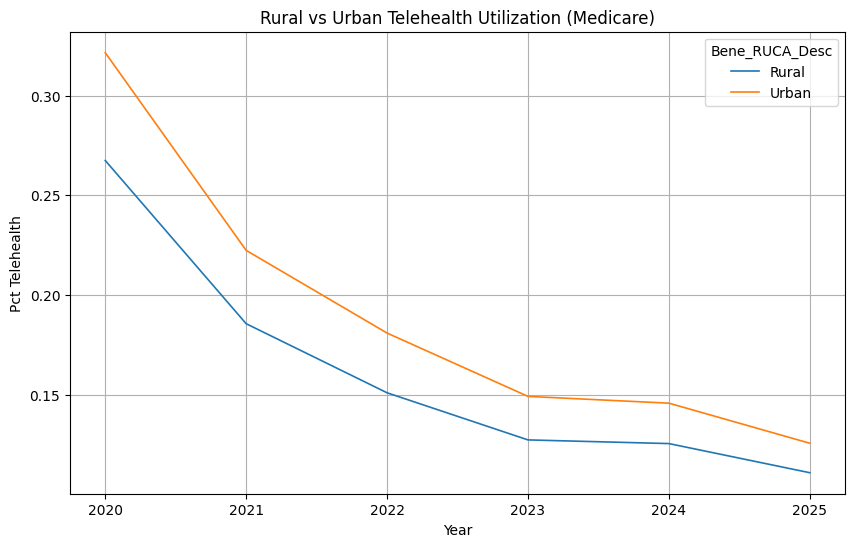

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("TMEDTREND_PUBLIC_250827.csv")

# rural vs urban only
ruca_df = df[df['Bene_RUCA_Desc'].isin(['Rural', 'Urban'])]

ruca_summary = ruca_df.groupby(['Year', 'Bene_RUCA_Desc'])['Pct_Telehealth'].mean().reset_index()
ruca_summary = ruca_summary.rename(columns={'Pct_Telehealth': 'mean_pct'})

plt.figure(figsize=(10, 6))
sns.lineplot(data=ruca_summary, x='Year', y='mean_pct', hue='Bene_RUCA_Desc', linewidth=1.2)
plt.title("Rural vs Urban Telehealth Utilization (Medicare)")
plt.xlabel("Year")
plt.ylabel("Pct Telehealth")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# データ読み込み
df = pd.read_csv("TMEDTREND_PUBLIC_250827.csv")

# 絞り込み：National × Rural/Urban × Quarterly × 2020
sub = df[
    (df['Bene_Geo_Desc'] == 'National') &
    (df['Bene_RUCA_Desc'].isin(['Rural', 'Urban'])) &
    (df['quarter'].isin(['1', '2', '3', '4'])) &
    (df['Year'] == 2020)
].copy() # Explicitly create a copy to avoid SettingWithCopyWarning

# ダミー変数
sub['Rural'] = (sub['Bene_RUCA_Desc'] == 'Rural').astype(int)
sub['Post'] = (sub['quarter'].astype(int) >= 2).astype(int)

# DiD 回帰 (Difference-in-Differences regression)
# Using statsmodels for OLS regression with formula interface
m = smf.ols('Pct_Telehealth ~ Rural * Post', data=sub).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:         Pct_Telehealth   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     53.11
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           6.95e-17
Time:                        20:50:28   Log-Likelihood:                 70.760
No. Observations:                  64   AIC:                            -133.5
Df Residuals:                      60   BIC:                            -124.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0770      0.029      2.633      0.0

                            OLS Regression Results                            
Dep. Variable:         Pct_Telehealth   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     1.490
Date:                Wed, 03 Dec 2025   Prob (F-statistic):              0.568
Time:                        20:55:46   Log-Likelihood:                 33.608
No. Observations:                  12   AIC:                            -45.22
Df Residuals:                       1   BIC:                            -39.88
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

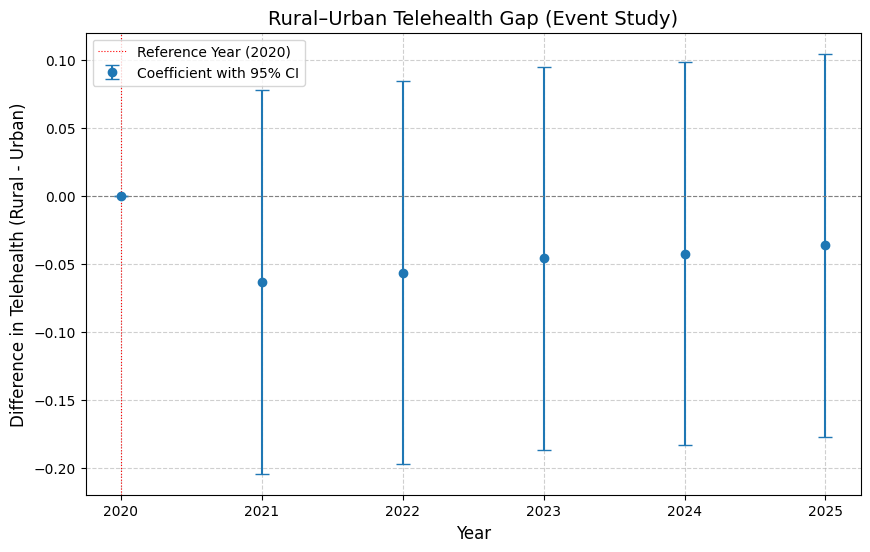

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("TMEDTREND_PUBLIC_250827.csv")

# Quarterly → Year-level mean
year_df = df[
    (df['Bene_Geo_Desc'] == 'National') &
    (df['Bene_RUCA_Desc'].isin(['Rural', 'Urban'])) &
    (df['quarter'].isin(['1', '2', '3', '4']))
].copy() # Ensure working on a copy

year_df = year_df.groupby(['Year', 'Bene_RUCA_Desc'])['Pct_Telehealth'].mean().reset_index()

# Rural dummy
year_df['Rural'] = (year_df['Bene_RUCA_Desc'] == 'Rural').astype(int)

# --- Event study model (two-way fixed effects) ---
# To mimic fixest's i(Year, Rural, ref = 2020) | Bene_RUCA_Desc + Year
# We will use statsmodels.formula.api.ols and manually create interaction terms for event study.
# C(Year, Treatment(2020)) handles Year fixed effects with 2020 as reference.

year_df_es = year_df.copy()

# Create interaction terms for Rural * Year (excluding Rural * Year_2020 as reference)
es_formula_parts = []
for year_val in sorted(year_df_es['Year'].unique()):
    if year_val != 2020:
        # Ensure the 'Year' column is used for filtering, not the dummy itself
        interaction_col = f'Rural_x_Year_{year_val}'
        year_df_es[interaction_col] = year_df_es['Rural'] * (year_df_es['Year'] == year_val).astype(int)
        es_formula_parts.append(interaction_col)

# Formula: Pct_Telehealth ~ C(Year, Treatment(2020)) + Rural_x_Year_XXX terms
# Removed 'Rural' main effect to avoid model saturation with limited data.
formula_str = "Pct_Telehealth ~ C(Year, Treatment(2020))"
if es_formula_parts:
    formula_str += " + " + " + ".join(es_formula_parts)

est = smf.ols(formula_str, data=year_df_es).fit()

print(est.summary())

# --- Event-study plot ---
# Extract coefficients and standard errors for the event-time interaction terms
coefs = {}
ses = {}
years_for_plot = sorted(year_df_es['Year'].unique())

# Add 2020 as the reference point (coefficient of 0, SE of 0)
coefs[2020] = 0.0
ses[2020] = 0.0

for year_val in years_for_plot:
    if year_val != 2020:
        interaction_col = f'Rural_x_Year_{year_val}'
        if interaction_col in est.params.index:
            coefs[year_val] = est.params[interaction_col]
            ses[year_val] = est.bse[interaction_col]

plot_df = pd.DataFrame({
    'Year': list(coefs.keys()),
    'Coefficient': list(coefs.values()),
    'SE': list(ses.values())
}).sort_values('Year')

# Plotting event study coefficients with 95% confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(plot_df['Year'], plot_df['Coefficient'],
             yerr=1.96 * plot_df['SE'], fmt='o', capsize=5, label='Coefficient with 95% CI')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line
plt.axvline(2020, color='red', linestyle=':', linewidth=0.8, label='Reference Year (2020)')
plt.title("Rural–Urban Telehealth Gap (Event Study)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Difference in Telehealth (Rural - Urban)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(plot_df['Year'].unique())
plt.legend()
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv("TMEDTREND_PUBLIC_250827.csv")

# Rural/Urban × 年度平均 Telehealth 利用率
year_ru_df = df[
    (df['Bene_Geo_Desc'] == "National") &
    (df['Bene_RUCA_Desc'].isin(["Rural", "Urban"])) &
    (df['quarter'].isin(["1","2","3","4"]))
].groupby(['Year', 'Bene_RUCA_Desc'])['Pct_Telehealth'].mean().reset_index()

print(year_ru_df)

    Year Bene_RUCA_Desc  Pct_Telehealth
0   2020          Rural        0.247950
1   2020          Urban        0.319987
2   2021          Rural        0.178275
3   2021          Urban        0.241594
4   2022          Rural        0.141472
5   2022          Urban        0.197794
6   2023          Rural        0.119766
7   2023          Urban        0.165553
8   2024          Rural        0.120053
9   2024          Urban        0.162566
10  2025          Rural        0.122588
11  2025          Urban        0.158938


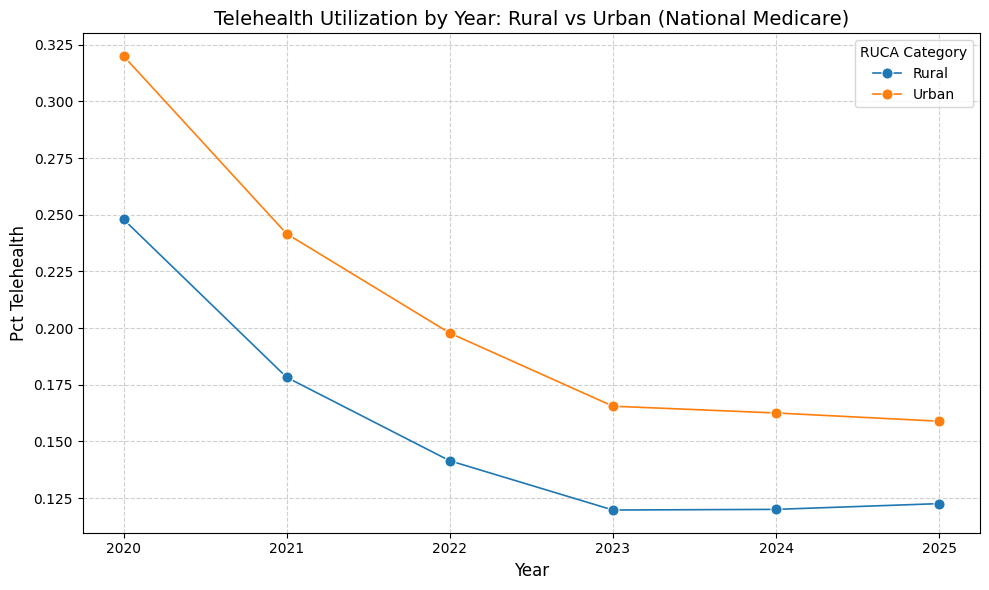

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure year_ru_df is available, though it should be from the previous cell
# If running this cell independently, ensure year_ru_df is defined
# For example:
# import pandas as pd
# df = pd.read_csv("TMEDTREND_PUBLIC_250827.csv")
# year_ru_df = df[
#     (df['Bene_Geo_Desc'] == "National") &
#     (df['Bene_RUCA_Desc'].isin(["Rural", "Urban"])) &
#     (df['quarter'].isin(["1","2","3","4"]))
# ].groupby(['Year', 'Bene_RUCA_Desc'])['Pct_Telehealth'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=year_ru_df, x='Year', y='Pct_Telehealth',
             hue='Bene_RUCA_Desc', marker='o', linewidth=1.2, markersize=8)

plt.title("Telehealth Utilization by Year: Rural vs Urban (National Medicare)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Pct Telehealth", fontsize=12)
plt.legend(title="RUCA Category")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(year_ru_df['Year'].unique())
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# データ読み込み
df = pd.read_csv("TMEDTREND_PUBLIC_250827.csv")

# 絞り込み：National × Rural/Urban × Quarterly × 2020
sub = df[
    (df['Bene_Geo_Desc'] == 'National') &
    (df['Bene_RUCA_Desc'].isin(['Rural', 'Urban'])) &
    (df['quarter'].isin(['1', '2', '3', '4'])) &
    (df['Year'] == 2020)
].copy() # Explicitly create a copy to avoid SettingWithCopyWarning

# ダミー変数
sub['Rural'] = (sub['Bene_RUCA_Desc'] == 'Rural').astype(int)
sub['Post'] = (sub['quarter'].astype(int) >= 2).astype(int)

# DiD 回帰 (Difference-in-Differences regression)
# Using statsmodels for OLS regression with formula interface
m = smf.ols('Pct_Telehealth ~ Rural * Post', data=sub).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:         Pct_Telehealth   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     53.11
Date:                Wed, 03 Dec 2025   Prob (F-statistic):           6.95e-17
Time:                        20:56:54   Log-Likelihood:                 70.760
No. Observations:                  64   AIC:                            -133.5
Df Residuals:                      60   BIC:                            -124.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0770      0.029      2.633      0.0

                            OLS Regression Results                            
Dep. Variable:         Pct_Telehealth   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     1.490
Date:                Wed, 03 Dec 2025   Prob (F-statistic):              0.568
Time:                        20:58:13   Log-Likelihood:                 33.608
No. Observations:                  12   AIC:                            -45.22
Df Residuals:                       1   BIC:                            -39.88
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

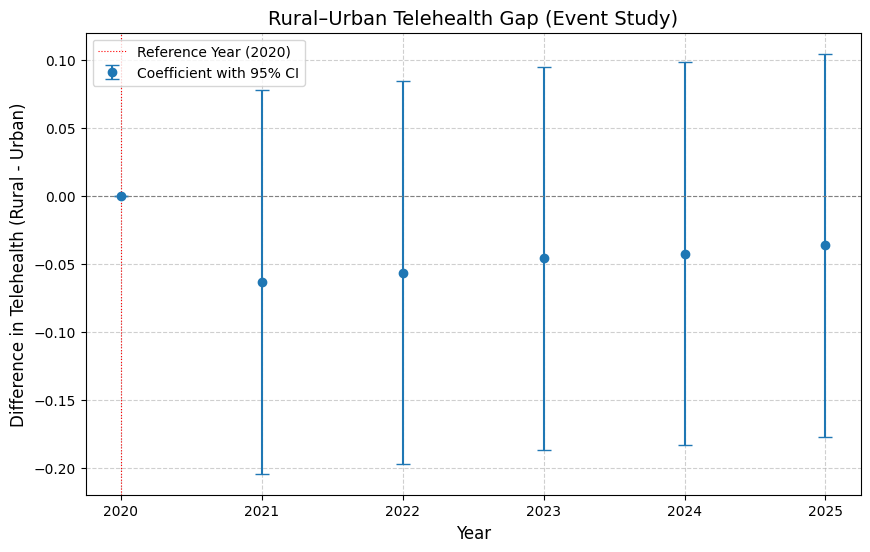

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("TMEDTREND_PUBLIC_250827.csv")

# Data preparation: Filter and aggregate to annual means for Rural/Urban
year_df_es = df[
    (df['Bene_Geo_Desc'] == 'National') &
    (df['Bene_RUCA_Desc'].isin(['Rural', 'Urban'])) &
    (df['quarter'].isin(['1', '2', '3', '4']))
].groupby(['Year', 'Bene_RUCA_Desc'])['Pct_Telehealth'].mean().reset_index()

# Create Rural dummy
year_df_es['Rural'] = (year_df_es['Bene_RUCA_Desc'] == 'Rural').astype(int)

# --- Event study model (two-way fixed effects) ---
# Mimicking fixest's i(Year, Rural, ref = 2020) | Bene_RUCA_Desc + Year
# We manually create interaction terms and use OLS from statsmodels.

# Create interaction terms for Rural * Year (excluding Rural * Year_2020 as reference)
es_formula_parts = []
for year_val in sorted(year_df_es['Year'].unique()):
    if year_val != 2020:
        interaction_col = f'Rural_x_Year_{year_val}'
        year_df_es[interaction_col] = year_df_es['Rural'] * (year_df_es['Year'] == year_val).astype(int)
        es_formula_parts.append(interaction_col)

# Formula: Pct_Telehealth ~ C(Year, Treatment(2020)) + Rural_x_Year_XXX terms
# The Bene_RUCA_Desc fixed effect from fixest is implicitly handled by the model structure
# with year fixed effects and the interaction terms. Explicitly adding 'Rural' as a main
# effect would lead to perfect multicollinearity given the current data structure (12 obs, 12 params).
formula_str = "Pct_Telehealth ~ C(Year, Treatment(2020))"
if es_formula_parts:
    formula_str += " + " + " + ".join(es_formula_parts)

est = smf.ols(formula_str, data=year_df_es).fit()

print(est.summary())

# --- Event-study plot ---
# Extract coefficients and standard errors for the event-time interaction terms
coefs = {}
ses = {}
years_for_plot = sorted(year_df_es['Year'].unique())

# Add 2020 as the reference point (coefficient of 0, SE of 0)
coefs[2020] = 0.0
ses[2020] = 0.0

for year_val in years_for_plot:
    if year_val != 2020:
        interaction_col = f'Rural_x_Year_{year_val}'
        if interaction_col in est.params.index:
            coefs[year_val] = est.params[interaction_col]
            ses[year_val] = est.bse[interaction_col]

plot_df = pd.DataFrame({
    'Year': list(coefs.keys()),
    'Coefficient': list(coefs.values()),
    'SE': list(ses.values())
}).sort_values('Year')

# Plotting event study coefficients with 95% confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(plot_df['Year'], plot_df['Coefficient'],
             yerr=1.96 * plot_df['SE'], fmt='o', capsize=5, label='Coefficient with 95% CI')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8) # Zero line
plt.axvline(2020, color='red', linestyle=':', linewidth=0.8, label='Reference Year (2020)')
plt.title("Rural–Urban Telehealth Gap (Event Study)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Difference in Telehealth (Rural - Urban)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(plot_df['Year'].unique())
plt.legend()
plt.show()